<a href="https://colab.research.google.com/github/snigdhasaha7/diffusion-for-photoacoustic/blob/main/weekly_notebooks/SD_Winter_Working_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import functools
import torch
import tqdm
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import Adam
from torch.utils.data import DataLoader

# if run remotely: import utils from github repo
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    if os.path.isdir('./diffusion-for-photoacoustic/') == False:
        ! git clone https://github.com/snigdhasaha7/diffusion-for-photoacoustic.git
    sys.path.append('./diffusion-for-photoacoustic/')
# if run locally: add parent path
else:
    parent_dir = os.path.dirname(os.getcwd())
    sys.path.append(parent_dir)
    
import samplers
from models import ScoreNet
from sdes import Classic, VarianceExploding, VariancePreserving, SubVariancePreserving
from tasks import AddGaussianNoise, inpaint, gaussian_downsampling, PAT_forward

In [ ]:
n_epochs = 50
batch_size = 64
lr = 1e-4
device = 'cuda'         #@param ['cuda', 'cpu']
dataset = 'MNIST'    #@param ['MNIST', 'FashionMNIST', 'CIFAR10']
sde_type = 'subvp'        #@param ['classic', 'vp', 've', 'subvp']

if sde_type == "classic":
  param = 0.01 #@param {'type' : 'number'}
  sde_params = [param,]
else:
  param1 = 0.01 #@param {'type' : 'number'}
  param2 = 5 #@param {'type' : 'number'}
  sde_params = [param1, param2] # [classic: sigma][vp: b_min, b_max][ve|subve: s_min, s_max]

gen_sampler = 'pc'     #@param ['em', 'pc', 'ode']
denoise_sampler = 'pc' #@param ['em', 'pc']
noise_std = .1
training = True
denoising = True
psnr = samplers.psnr

In [ ]:
# SDE
if sde_type == 've':
    SDE = VarianceExploding()
    sigma_min, sigma_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
elif sde_type == 'vp':
    SDE = VariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'subvp':
    SDE = SubVariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'classic':
    SDE = Classic()
    sigma = sde_params
    params_str = '{}'.format(sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma=sigma)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma=sigma)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma=sigma)
    
# sampler for generation
if gen_sampler == 'em':
    sampler = samplers.Euler_Maruyama_sampler
elif gen_sampler == 'pc':
    sampler = samplers.pc_sampler
elif gen_sampler == 'ode':
    sampler = samplers.ode_sampler

# sampler for denoising
if denoise_sampler == 'em':
    denoiser = samplers.Euler_Maruyama_denoiser
elif denoise_sampler == 'pc':
    denoiser = samplers.pc_denoiser

# training dataset
if training:
    if dataset == 'MNIST':
        train_transforms = transforms.Compose([transforms.ToTensor()])
        train_dataset = MNIST('.', train=True, transform=train_transforms, download=True);
    elif dataset == 'FashionMNIST':
        train_transforms = transforms.Compose([transforms.ToTensor()])
        train_dataset = FashionMNIST('.', train=True, transform=train_transforms, download=True);
    elif dataset == 'CIFAR10':
        train_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
             transforms.Resize((28,28)),
             transforms.Grayscale(num_output_channels=1)])
        train_dataset = CIFAR10('.', train=True, transform=train_transforms, download=True);
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

if denoising:
    if dataset == 'MNIST':
        test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
        test_dataset = MNIST('.', train=False, transform=test_transforms, download=True);
    elif dataset == 'FashionMNIST':
        test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
        test_dataset = FashionMNIST('.', train=False, transform=test_transforms, download=True);
    elif dataset == 'CIFAR10':
        test_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
             transforms.Resize((28,28)),
             transforms.Grayscale(num_output_channels=1),
             AddGaussianNoise(noise_std)])
        test_dataset = CIFAR10('.', train=False, transform=test_transforms, download=True);
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4);

# Set up denoiser
def denoise(raw_images, denoiser, lbda=.5, lbda_schedule='constant', lbda_param=1, a=0.5, operator_P=None,
            subsampling_L=None, transformation_T=None, report_PSNR=False, clean_images=None, 
            num_steps=500, task='denoise'):
    denoised = denoiser(raw_images,
                    score_model,
                    lbda,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    drift_coeff_fn,
                    task,
                    lbda_schedule,
                    lbda_param,
                    a,
                    operator_P,
                    subsampling_L,
                    transformation_T,
                    num_steps=num_steps,
                    report_PSNR=report_PSNR,
                    clean_images=clean_images, 
                    device=device)
    return denoised

# helper function to plot samples
def plot_before_after(clean_images, imgs_before, imgs_after, title=""):
    assert(imgs_before.shape[0] == imgs_after.shape[0])
    fig, axs = plt.subplots(2, imgs_before.shape[0], figsize=(16, 5))
    for i, image in enumerate(imgs_before):
        im = axs[0][i].imshow(image.cpu().permute(1, 2, 0).squeeze())
        axs[0][i].set_xticks([])
        axs[0][i].set_yticks([])
    for i, image in enumerate(imgs_after):
        im = axs[1][i].imshow(image.cpu().permute(1, 2, 0).squeeze())
        axs[1][i].set_xticks([])
        axs[1][i].set_yticks([])
        plt.colorbar(im, ax=axs[1,i])
        if clean_images is not None:
            clean = clean_images[i].cpu().permute(1,2,0).squeeze()
            noisy = image.cpu().permute(1,2,0).squeeze()
            psnr_val = psnr(clean, noisy).item()
            axs[1][i].set_title('PSNR: {:.3f}'.format(psnr_val), y=-0.2)
    fig.suptitle(title, size=20)

# model + optimizer
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)

# loss
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

# checkpoint folder varies if on colab or local
if IN_COLAB:
    checkpoint_dir = './diffusion-for-photoacoustic/checkpoints/'
else:
    checkpoint_dir = './checkpoints/'

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
checkpoint_path = checkpoint_dir+'ckpt_{}_{}epochs_{}_{}.pth'.format(dataset.lower(), n_epochs, sde_type, params_str)

# load checkpoint if existing
if os.path.exists(checkpoint_path): 
    score_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# otherwise train from scratch
else:
    tqdm_epoch = tqdm.notebook.trange(n_epochs)
    for epoch in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        for x, y in train_loader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0] 
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
        torch.save(score_model.state_dict(), checkpoint_path)

In [ ]:
# PAT parameters
# --------------

# Fixed parameters
R_ring         = 0.04
M              = 28
N              = 28
V_sound        = 1500
px             = 1e-3
py             = 1e-3

# Free parameters
N_sample       = 56
N_transducer   = 28

T_min = (R_ring - py * (M / 2 - 0.5)) / V_sound
T_max = np.sqrt((R_ring + py * (M / 2 - 0.5))**2 + (px * (N / 2 - 0.5))**2) / V_sound
dt    = (T_max - T_min) / (N_sample - 1)

oversample  = 10
padsample   = 50
Band        = 1 /dt / 2

PAT_config=[N_transducer, R_ring, px, py, M, N, dt, N_sample, oversample, padsample, T_min, Band, V_sound]

100%|██████████| 28/28 [00:11<00:00,  2.53it/s]


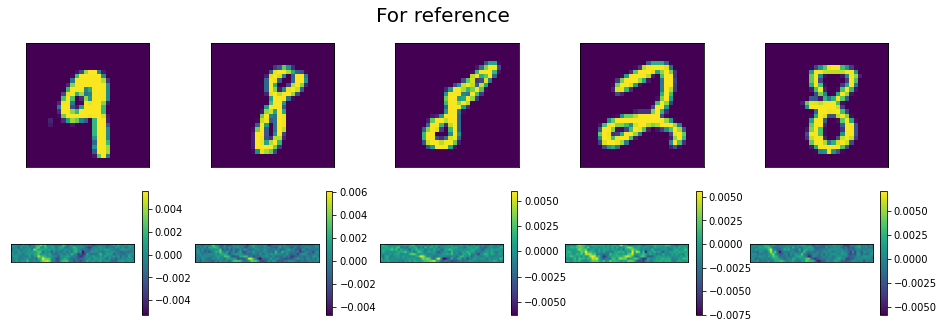

In [ ]:
num_images = 5
data, _ = next(iter(train_loader))
clean_images = data[:num_images].to(device)

rmd = [0,1,2,3,4,5,6,7,8,9,18,19,20,21,22,23,24,25,26,27]

pat_images, P, L, T = PAT_forward(clean_images, PAT_config, add_noise=True, noise=0.0008, remove_transducers=True, removed_transducers=rmd)
plot_before_after(None, clean_images, pat_images, title="For reference")

  0%|          | 0/5000 [00:00<?, ?it/s]

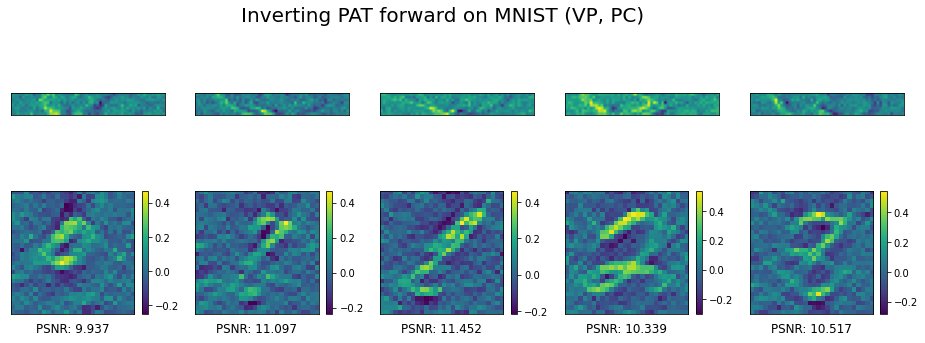

In [ ]:
# Denoised images
# best results lbda = 0.8, lbda_param = 1
# second results lbda = 0.8, lbda_param = 0.01

# relu best lbda = 1, [0.5, 0.05]
# sigmoid best lbda=0.002, [17, 0.015] (params as tensors)

alpha = 1e-7

reversed_images, metrics = denoise(pat_images, denoiser, lbda=0.015, lbda_schedule='sigmoid', lbda_param=[torch.tensor(30),torch.tensor(0.015)], a=alpha,
                          operator_P=P, subsampling_L=L, transformation_T=T, num_steps=5000, 
                          report_PSNR=True, clean_images=clean_images, task='depat_modified')

plot_before_after(clean_images, pat_images, reversed_images, title="Inverting PAT forward on MNIST (VP, PC)")

  0%|          | 0/500 [00:00<?, ?it/s]

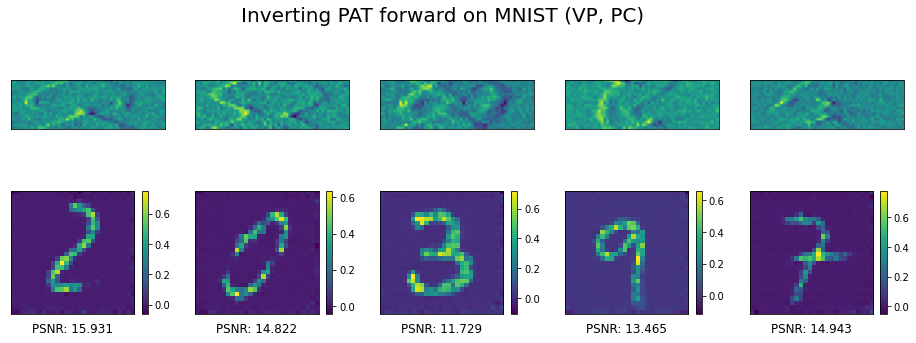

In [ ]:
# additional denoising

denoised_images, metrics = denoise(reversed_images, denoiser, lbda=.04, lbda_schedule='linear', lbda_param=10,
                                   report_PSNR=True, clean_images=clean_images, task='denoise')

plot_before_after(clean_images=clean_images, imgs_before=pat_images, imgs_after=denoised_images, title="Inverting PAT forward on MNIST (VP, PC)")

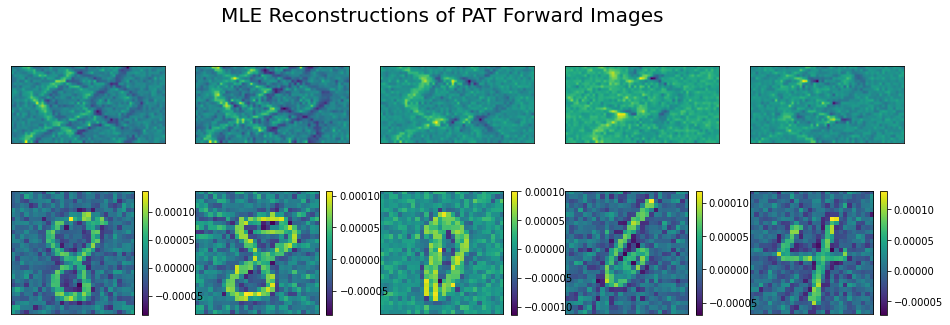

In [ ]:
A = torch.matmul(P, torch.matmul(L, T)).cpu()
l = 0.5

recons = []

for pi in pat_images:
  term1 = torch.linalg.inv(torch.matmul(A.T, A) + l*torch.eye(A.size(dim=1))).cpu()
  term2 = torch.matmul(term1, A.T).cpu()
  mle_recon = torch.matmul(term2, pi.flatten().cpu())

  recons.append(torch.reshape(mle_recon, (1, 28, 28)))

recons = torch.unsqueeze(torch.cat(recons), 1)

plot_before_after(imgs_before=pat_images, imgs_after=recons, title="MLE Reconstructions of PAT Forward Images", clean_images=None)

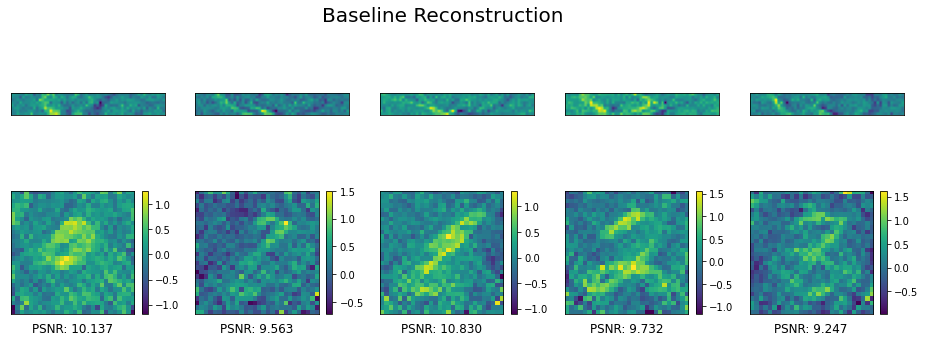

In [ ]:
A = torch.matmul(torch.matmul(P, L), T).to("cpu")

recons = []

for i in range(len(pat_images)):
  y_t = pat_images[i].cpu().squeeze()
  x_t = torch.randn((28,28)).squeeze()

  flat_y_t = torch.unsqueeze(torch.flatten(y_t, start_dim=0), dim=1)
  flat_x_t = torch.unsqueeze(torch.flatten(x_t, start_dim=0), dim=1)

  term1 = torch.inverse(torch.matmul(A.T, A) + alpha * torch.eye(A.shape[1], device=A.device))

  ans = torch.matmul(term1, torch.matmul(A.T, flat_y_t)).reshape(1,28,28)

  recons.append(ans)

recons = torch.stack(recons)

plot_before_after(clean_images, pat_images, recons, title="Baseline Reconstruction")